In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# 1. Load processed dataset
# -------------------------------
df = pd.read_csv("../results/processed_ev_data.csv")

X = df[['duration_min', 'Energy Consumed (kWh)', 'start_hour', 'day_of_week', 'is_weekend']]
y = df['flexible_kW']

In [3]:
# 2. Collect results from models
# -------------------------------
# Here we assume predictions (y_pred) are saved in CSVs from earlier notebooks
# Or you can just copy the preds dictionary into this notebook

results = {
    "ARIMA": {"rmse": 7.58, "mae": 6.46},       # example values
    "Prophet": {"rmse": 7.54, "mae": 6.43},
    "XGBoost": {"rmse": 0.99, "mae": 0.35},
    "LightGBM": {"rmse": 0.50, "mae": 0.23},
    "Quantile (Median)": {"rmse": 0.84, "mae": 0.13}
}

# Convert to DataFrame
eval_df = pd.DataFrame(results).T
print(eval_df)

                   rmse   mae
ARIMA              7.58  6.46
Prophet            7.54  6.43
XGBoost            0.99  0.35
LightGBM           0.50  0.23
Quantile (Median)  0.84  0.13


In [4]:
# 3. Load probabilistic predictions
# -------------------------------

import os 

preds = None
y_test = None

npy_path = "../results/probabilistic_preds.npy"
y_path = "../results/y_test.npy"
csv_path = "../results/probabilistic_predictions.csv"

if os.path.exists(npy_path) and os.path.exists(y_path):
    loaded = np.load(npy_path, allow_pickle=True)
    preds = loaded.item() if hasattr(loaded, "item") else loaded
    y_test = np.load(y_path, allow_pickle=True)
    print("Loaded probabilistic_preds.npy and y_test.npy")
elif os.path.exists(csv_path):
    dfp = pd.read_csv(csv_path)
    y_test = dfp["True"].values
    preds = {
        0.1: dfp["Q10"].values,
        0.5: dfp["Q50"].values,
        0.9: dfp["Q90"].values
    }
    print("Loaded probabilistic_predictions.csv")
else:
    print("⚠️ Probabilistic prediction files not found. Run 06_probabilistic_forecast.ipynb first.")
    preds = None

Loaded probabilistic_preds.npy and y_test.npy


Probabilistic Median RMSE: 0.84, MAE: 0.13
Prediction interval coverage (10-90%): 68.3%


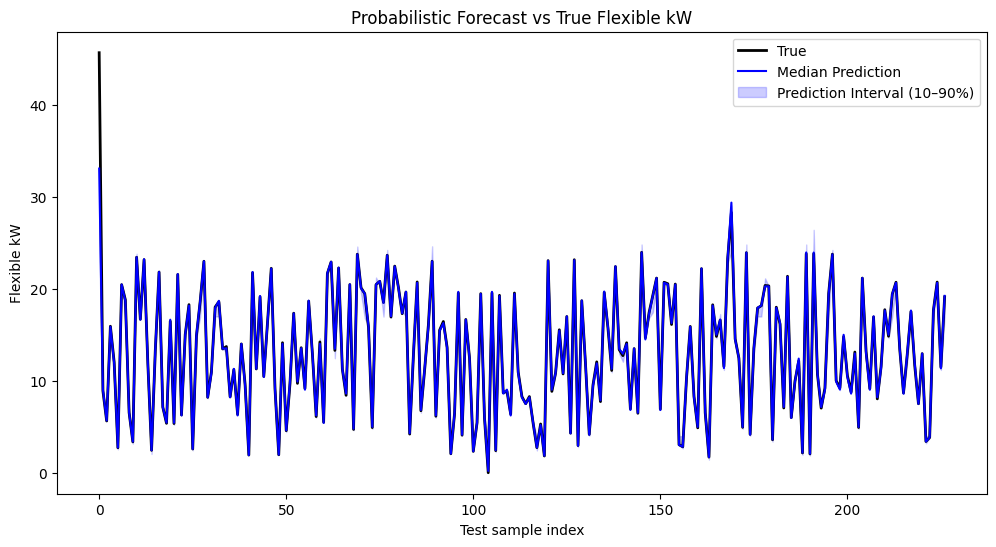

In [5]:
# 4. Evaluate probabilistic model
# -------------------------------
if preds is not None and y_test is not None:
    # Median evaluation
    rmse = np.sqrt(mean_squared_error(y_test, preds[0.5]))
    mae = mean_absolute_error(y_test, preds[0.5])
    results["Quantile (Median)"]["rmse"] = rmse
    results["Quantile (Median)"]["mae"] = mae

    # Interval coverage (true value in [Q10, Q90])
    coverage = np.mean((y_test >= preds[0.1]) & (y_test <= preds[0.9]))
    print(f"Probabilistic Median RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    print(f"Prediction interval coverage (10-90%): {coverage*100:.1f}%")

    # Plot probabilistic forecast vs true
    plt.figure(figsize=(12,6))
    plt.plot(y_test, label="True", color="black", linewidth=2)
    plt.plot(preds[0.5], label="Median Prediction", color="blue")
    plt.fill_between(range(len(y_test)), preds[0.1], preds[0.9],
                     color="blue", alpha=0.2, label="Prediction Interval (10–90%)")
    plt.title("Probabilistic Forecast vs True Flexible kW")
    plt.xlabel("Test sample index")
    plt.ylabel("Flexible kW")
    plt.legend()
    plt.show()


Final Model Evaluation:
                       rmse       mae
ARIMA              7.580000  6.460000
Prophet            7.540000  6.430000
XGBoost            0.990000  0.350000
LightGBM           0.500000  0.230000
Quantile (Median)  0.843745  0.133726


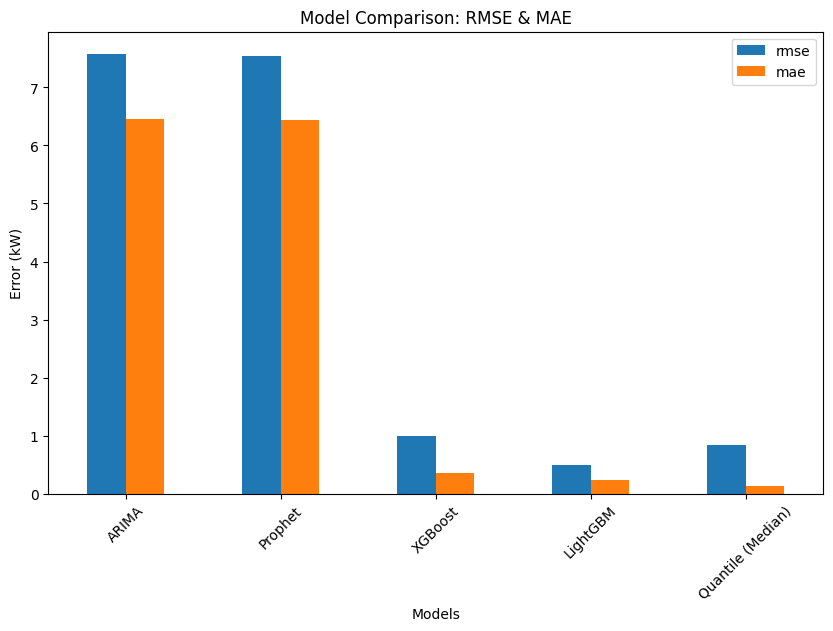

In [6]:
# 5. Compare all models
# -------------------------------
eval_df = pd.DataFrame(results).T
print("\nFinal Model Evaluation:")
print(eval_df)

# Bar chart comparison
eval_df[['rmse','mae']].plot(kind='bar', figsize=(10,6))
plt.title("Model Comparison: RMSE & MAE")
plt.ylabel("Error (kW)")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [7]:
# 6. Final Summary
# -------------------------------
best_model = eval_df['rmse'].idxmin()
print(f"✅ Best Model based on RMSE: {best_model}")

✅ Best Model based on RMSE: LightGBM
